0.13120588676919365 0.9777143715271484


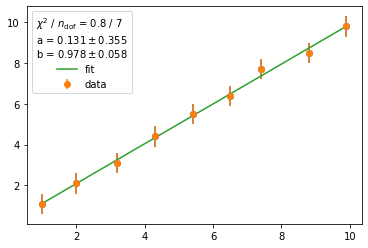

In [3]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares
def line(x,a,b):
    return a+x*b

# generate random toy data with random offsets in y
np.random.seed(1)
data_x = [1,2,3.2,4.3,5.4,6.5,7.4,8.8,9.9]
data_yerr = 0.5  # could also be an array
data_y = [1.1,2.1,3.1,4.4,5.5,6.4,7.7,8.5,9.8]
#line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

plt.errorbar(data_x,data_y,data_yerr,fmt="o")
least_squares = LeastSquares(data_x,data_y,data_yerr,line)
m = Minuit(least_squares, a=0, b=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

print(*m.values)
# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
fit_y=[]
for xi in data_x:
    fit_y.append(line(xi,*m.values))
    
plt.plot(data_x, fit_y, label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info))

In [2]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from iminuit.util import make_with_signature, describe
from matplotlib import pyplot as plt
import numpy as np


# norm_pdf from numba_stats is a compiled function
# without a function signature, so we create one
from numba_stats import norm_pdf, norm_cdf

print(f"before {describe(norm_pdf)=}")
normal_pdf = make_with_signature(norm_pdf, "x", "μ", "σ")
print(f"after  {describe(normal_pdf)=}")

# generate two data sets which are fitted simultaneously
rng = np.random.default_rng(1)
width = 2.0
data1 = rng.normal(0, width, size=1000)
data2 = rng.normal(5, width, size=1000)

# rename non-shared parameters so that they are fitted independently
pdf1 = make_with_signature(normal_pdf, μ='μ_1')
pdf2 = make_with_signature(normal_pdf, μ='μ_2')

# combine two log-likelihood functions by adding them
lh = UnbinnedNLL(data1, pdf1) + UnbinnedNLL(data2, pdf2)

print(f"{describe(lh)=}")



def plot(cost, xe, minuit, ax, **style):
    signature = describe(cost)
    data = cost.data

    values = minuit.values[signature]
    errors = minuit.errors[signature]

    cx = (xe[1:] + xe[:-1]) / 2

    ym = np.diff(norm_cdf(xe, *values)) * np.sum(w)
    t = []
    for n, v, e in zip(signature, values, errors):
        t.append(f"${n} = {v:.3f} ± {e:.3f}$")
    ax.plot(cx, ym, label="\n".join(t), **style)

m = Minuit(lh, μ_1=1, μ_2=2, σ=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

hists = [np.histogram(lhi.data, bins=50) for lhi in lh]

# draw data and model with initial parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    cx = (xe[1:] + xe[:-1]) / 2
    axi.errorbar(cx, w, np.sqrt(w), fmt="ok", capsize=0, zorder=0)
    plot(lhi, xe, m, axi, ls="--")

m.migrad()

# draw model with fitted parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    plot(lhi, xe, m, axi)
    axi.legend()



ModuleNotFoundError: No module named 'numba_stats'

['x', 'a', 'b', 'Ax']
['x', 'a', 'b', 'Ax1']
1.4379586381674951 2.0933998229332462 1.1 1.2


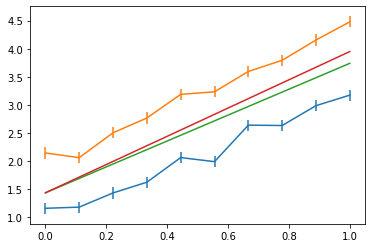

In [3]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from iminuit.util import make_with_signature, describe
from matplotlib import pyplot as plt
import numpy as np

from iminuit.cost import LeastSquares
def line(x,a,b,Ax):
    return a+x*b*Ax

np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2,1.1) + data_yerr * np.random.randn(len(data_x))
data_yerr2 = 0.1
data_y2 = line(data_x,2,2.2,1.1)+data_yerr2 * np.random.randn(len(data_x))
plt.errorbar(data_x,data_y,data_yerr)
plt.errorbar(data_x,data_y2,data_yerr2)
print(describe(line))
Ax1 = make_with_signature(line,Ax = 'Ax1')
Ax2 = make_with_signature(line,Ax = 'Ax2')
print(describe(Ax1))
#least_squares = LeastSquares(data_x,data_y,data_yerr,line)+LeastSquares(data_x,data_y2,data_yerr2,line)
least_squares = LeastSquares(data_x,data_y,data_yerr,Ax1)+LeastSquares(data_x,data_y2,data_yerr2,Ax2)

m = Minuit(least_squares, a=1, b=1,Ax1 = 1.1,Ax2 = 1.2)
m.fixed["Ax1"] = True
m.fixed["Ax2"] = True
m.migrad()

m.hesse() 
print(*m.values)
plt.plot(data_x, line(data_x, m.values[0],m.values[1],m.values[2]), label="fit")
plt.plot(data_x, line(data_x, m.values[0],m.values[1],m.values[3]), label="fit")
